# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find optimal location for restaurant in Bali, in here Since there are lots of restaurants in Bali we will try to detect **locations that are near with recommmendation restaurant** ,**easy to access for costumer** and also **close to regency or city center**.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* near recommended restaurant (any type of restaurant)
* easy to access for costumer, that means close to the airport or bus terminal
* close to the regency or city center

Following data sources will be needed to extract/generate the required information:
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* take district and city name from wikipedia using **beautifulSoup**
* coordinate of Bali will be obtained using **geopy**

In [1]:
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import folium
import pandas
import geopy
import json
import re

In [2]:
source = requests.get('https://map-bms.wikipedia.org/wiki/Daftar_kabupaten_lan_kota_nang_Bali').text

In [3]:
data = bs(source,'lxml')

In [4]:
list_name = data.find_all('ol')

In [5]:
print(list_name[0])
print()
print(list_name[1])

<ol><li><a class="new" href="/w/index.php?title=Kabupaten_Buleleng&amp;action=edit&amp;redlink=1" title="Kabupaten Buleleng (kaca ora ana)">Kabupaten Buleleng</a></li>
<li><a href="/wiki/Kabupaten_Badung" title="Kabupaten Badung">Kabupaten Badung</a></li>
<li><a class="new" href="/w/index.php?title=Kabupaten_Bangli&amp;action=edit&amp;redlink=1" title="Kabupaten Bangli (kaca ora ana)">Kabupaten Bangli</a></li>
<li><a class="new" href="/w/index.php?title=Kabupaten_Gianyar&amp;action=edit&amp;redlink=1" title="Kabupaten Gianyar (kaca ora ana)">Kabupaten Gianyar</a></li>
<li><a href="/wiki/Kabupaten_Jembrana" title="Kabupaten Jembrana">Kabupaten Jembrana</a></li>
<li><a class="new" href="/w/index.php?title=Kabupaten_Karangasem&amp;action=edit&amp;redlink=1" title="Kabupaten Karangasem (kaca ora ana)">Kabupaten Karangasem</a></li>
<li><a class="new" href="/w/index.php?title=Kabupaten_Klungkung&amp;action=edit&amp;redlink=1" title="Kabupaten Klungkung (kaca ora ana)">Kabupaten Klungkung</a>

we found 6 regency in bali and 1 city in bali<br>
regency :
* Kabupaten Buleleng
* Kabupaten Bangli
* Kabupaten Gianyar
* Kabupaten Karangasem
* Kabupaten Klungkung
* Kabupaten Tabanan<br>

city:
* Kota Singaraja
<br>

when validation name regency and city in bali, there's  something that needs to be added. For regency add kabupaten jembrana and kabupaten Badung ,and for city not Singaraja, but Denpasar

let's see restaurant for each regency and city in bali

In [25]:
geolocator = geopy.geocoders.Nominatim(user_agent='hanyacontohemail@gmail.com')

In [32]:
buleleng_loc = geolocator.geocode('Buleleng, Bali')

In [33]:
print(f"Location of Bali in Indonesia latitude {buleleng_loc.latitude} and longintude {buleleng_loc.longitude}.")

Location of Bali in Indonesia latitude -8.1118271 and longintude 115.0909707.


In [36]:
buleleng_map = folium.Map(location=(buleleng_loc.latitude,buleleng_loc.longitude),zoom_start=12)
buleleng_map

In [37]:
client_id = 'D5P5JIHEG4LHWOLCWG2WNTKVBDWNHGDEHN4EPL501VWCKZ0D'
client_secret = 'WTNQHXKGSCLDUIMERNLXQOO1G1HAAF22CAV1LE1CXKW5EY43'
v = '20180323'
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {buleleng_loc.latitude},{buleleng_loc.longitude}&locate=id&near'

In [45]:
result = requests.get(url).json()

In [46]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [50]:
venues = result['response']['groups'][0]['items']
buleleng_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
buleleng_dataframe =buleleng_dataframe.loc[:, filtered_columns]
buleleng_dataframe['venue.categories'] = buleleng_dataframe.apply(get_category_type, axis=1)
buleleng_dataframe.columns = [col.split(".")[-1] for col in buleleng_dataframe.columns]
display(buleleng_dataframe.head())
print('data shape :',buleleng_dataframe.shape)

,name,categories,lat,lng
0,Rumah Cantik Kanaya,Cosmetics Shop,-8.115011,115.090739
1,KFC,Fried Chicken Joint,-8.112787,115.091357
2,Bakso Shabu Ala Jepang,Dim Sum Restaurant,-8.115325,115.091783
3,Apple Mart,Juice Bar,-8.113064,115.083493
4,KFC Singaraja,Fast Food Restaurant,-8.112808,115.091306


data shape : (20, 4)


In [43]:
buleleng_dataframe.categories.value_counts()

Fast Food Restaurant     3
Indonesian Restaurant    2
Café                     2
Harbor / Marina          1
Asian Restaurant         1
Basketball Stadium       1
Fried Chicken Joint      1
Bakery                   1
Juice Bar                1
Dim Sum Restaurant       1
Coffee Shop              1
Chinese Restaurant       1
Theater                  1
Field                    1
Cosmetics Shop           1
Flea Market              1
Name: categories, dtype: int64

In [227]:
def get_label(row):
    if (row.find('Restaurant') != -1) or (row.find('Café') != -1) or \
    (row.find('Fried') != -1) or (row.find('Coffee') != -1) or (row.find('Bar') != -1)\
    or (row.find('Bakery') != -1) or (row.find('Chips') != -1) or (row.find('Joint') != -1) \
    or (row.find('Food') != -1) or (row.find('Breakfast') != -1) or (row.find('Noodle') != -1)\
    or (row.find('Pizza') != -1):
        return 'Restaurant'
    else:
        return 'Not Restaurant'

In [77]:
buleleng_dataframe['label'] = buleleng_dataframe['categories'].apply(get_label)

In [78]:
buleleng_dataframe

,name,categories,lat,lng,label
0,Rumah Cantik Kanaya,Cosmetics Shop,-8.115011,115.090739,Not Restaurant
1,KFC,Fried Chicken Joint,-8.112787,115.091357,Restaurant
2,Bakso Shabu Ala Jepang,Dim Sum Restaurant,-8.115325,115.091783,Restaurant
3,Apple Mart,Juice Bar,-8.113064,115.083493,Restaurant
4,KFC Singaraja,Fast Food Restaurant,-8.112808,115.091306,Restaurant
5,Taman Kota Singaraja,Indonesian Restaurant,-8.116601,115.091395,Restaurant
6,KFC,Fast Food Restaurant,-8.112754,115.090011,Restaurant
7,Taman Kota Singaraja,Field,-8.117176,115.091517,Not Restaurant
8,Mailaku Roemah Nongkrong,Café,-8.114224,115.086177,Restaurant
9,BARAK Coffee Shop,Coffee Shop,-8.117099,115.090134,Restaurant


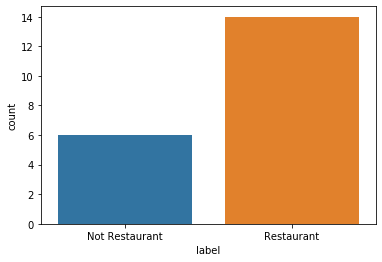

In [79]:
sns.countplot(buleleng_dataframe.label)

([<matplotlib.patches.Wedge at 0x1970ad78c88>,
 [Text(-0.6465637441936393, 0.8899187180267096, 'Restaurant'),
  Text(0.6465637441936392, -0.8899187180267097, 'Not Restaurant')],
 [Text(-0.3526711331965305, 0.4854102098327506, '70.0%'),
  Text(0.3526711331965304, -0.48541020983275074, '30.0%')])

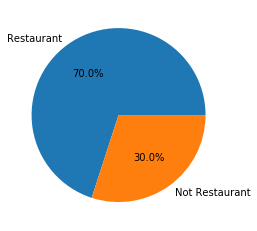

In [84]:
plt.pie(buleleng_dataframe.label.value_counts(),labels=['Restaurant','Not Restaurant'],autopct='%1.1f%%')

In [99]:
buleleng_map = folium.Map(location=(buleleng_loc.latitude,buleleng_loc.longitude),zoom_start=15)

In [100]:
colors = ['#009933','#0000ff']
for lat, lng, name, c in zip(buleleng_dataframe['lat'], buleleng_dataframe['lng'], buleleng_dataframe['name'],buleleng_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(buleleng_map)
buleleng_map 

In [102]:
bangli_loc = geolocator.geocode('Bangli, Bali')

In [103]:
print(f"Location of Bangli in Bali latitude {bangli_loc.latitude} and longintude {bangli_loc.longitude}.")

Location of Bali in Indonesia latitude -8.4603116 and longintude 115.3535198.


In [104]:
bangli_map = folium.Map(location=(bangli_loc.latitude,bangli_loc.longitude),zoom_start=12)
bangli_map

In [105]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {bangli_loc.latitude},{bangli_loc.longitude}&locate=id&near'

In [106]:
result = requests.get(url).json()

In [107]:
venues = result['response']['groups'][0]['items']
bangli_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
bangli_dataframe =bangli_dataframe.loc[:, filtered_columns]
bangli_dataframe['venue.categories'] = bangli_dataframe.apply(get_category_type, axis=1)
bangli_dataframe.columns = [col.split(".")[-1] for col in bangli_dataframe.columns]
display(bangli_dataframe.head())
print('data shape :',bangli_dataframe.shape)

,name,categories,lat,lng
0,Tukad Cepung Waterfall,Waterfall,-8.440978,115.387709
1,RM Ikan Mujair Pak Bagong,Indonesian Restaurant,-8.466652,115.350671
2,Desa Adat Tradisional Penglipuran (Balinese Tr...,Neighborhood,-8.422218,115.358913
3,Warung Makan Cinta Rasa,Fish & Chips Shop,-8.449124,115.358457
4,Air Terjun Dusun Kuning,River,-8.490977,115.355227


data shape : (5, 4)


In [117]:
bangli_dataframe['label'] = bangli_dataframe['categories'].apply(get_label)

In [118]:
bangli_dataframe

,name,categories,lat,lng,label
0,Tukad Cepung Waterfall,Waterfall,-8.440978,115.387709,Not Restaurant
1,RM Ikan Mujair Pak Bagong,Indonesian Restaurant,-8.466652,115.350671,Restaurant
2,Desa Adat Tradisional Penglipuran (Balinese Tr...,Neighborhood,-8.422218,115.358913,Not Restaurant
3,Warung Makan Cinta Rasa,Fish & Chips Shop,-8.449124,115.358457,Restaurant
4,Air Terjun Dusun Kuning,River,-8.490977,115.355227,Not Restaurant


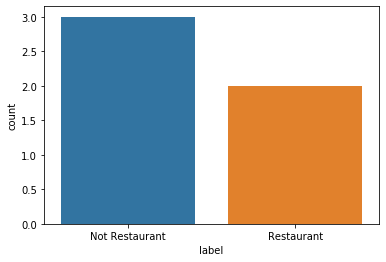

In [119]:
sns.countplot(bangli_dataframe.label)

([<matplotlib.patches.Wedge at 0x1970af52488>,
 [Text(-0.33991877217145816, 1.046162142464278, 'Not Restaurant'),
  Text(0.3399188701202255, -1.0461621106387813, 'Restaurant')],
 [Text(-0.18541023936624987, 0.5706338958896061, '60.0%'),
  Text(0.18541029279285026, -0.5706338785302443, '40.0%')])

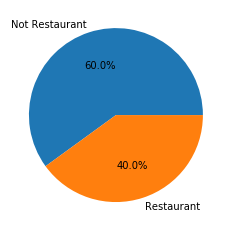

In [121]:
plt.pie(bangli_dataframe.label.value_counts(),labels=['Not Restaurant','Restaurant'],autopct='%1.1f%%')

In [125]:
bangli_map = folium.Map(location=(bangli_loc.latitude,bangli_loc.longitude),zoom_start=13)

In [126]:
colors = ['#009933','#0000ff']
for lat, lng, name, c in zip(bangli_dataframe['lat'], bangli_dataframe['lng'], bangli_dataframe['name'],bangli_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bangli_map)
bangli_map 

In [127]:
gianyar_loc = geolocator.geocode('Gianyar, Bali')

In [128]:
print(f"Location of Gianyar in Bali latitude {gianyar_loc.latitude} and longintude {gianyar_loc.longitude}.")

Location of Gianyar in Bali latitude -8.4603116 and longintude 115.3535198.


In [201]:
gianyar_map = folium.Map(location=(gianyar_loc.latitude,gianyar_loc.longitude),zoom_start=12)
gianyar_map

In [384]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {gianyar_loc.latitude},{gianyar_loc.longitude}&locate=id&near'

In [385]:
result = requests.get(url).json()

In [386]:
venues = result['response']['groups'][0]['items']
gianyar_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
gianyar_dataframe =gianyar_dataframe.loc[:, filtered_columns]
gianyar_dataframe['venue.categories'] = gianyar_dataframe.apply(get_category_type, axis=1)
gianyar_dataframe.columns = [col.split(".")[-1] for col in gianyar_dataframe.columns]
display(gianyar_dataframe.head())
print('data shape :',gianyar_dataframe.shape)

,name,categories,lat,lng
0,Pasar Senggol Gianyar,Night Market,-8.541477,115.326305
1,Holland Bakery,Bakery,-8.541081,115.321895
2,Taman Kota Gianyar,Park,-8.541023,115.322705
3,Lapangan Astina,Field,-8.542499,115.329407
4,Babi Guling Gianyar Warung Pande Oka,Balinese Restaurant,-8.541077,115.326252


data shape : (14, 4)


In [387]:
gianyar_dataframe['label'] = gianyar_dataframe['categories'].apply(get_label)

In [388]:
gianyar_dataframe

,name,categories,lat,lng,label
0,Pasar Senggol Gianyar,Night Market,-8.541477,115.326305,Not Restaurant
1,Holland Bakery,Bakery,-8.541081,115.321895,Restaurant
2,Taman Kota Gianyar,Park,-8.541023,115.322705,Not Restaurant
3,Lapangan Astina,Field,-8.542499,115.329407,Not Restaurant
4,Babi Guling Gianyar Warung Pande Oka,Balinese Restaurant,-8.541077,115.326252,Restaurant
5,Indomaret,Convenience Store,-8.546472,115.325807,Not Restaurant
6,Pasar Umum Gianyar,Farmers Market,-8.541907,115.326652,Not Restaurant
7,RM Ayam Goreng Asli Prambanan,Indonesian Restaurant,-8.539022,115.322439,Restaurant
8,TAMAN KOTA CIUNG WANARA,Park,-8.548875,115.324495,Not Restaurant
9,Babi Guling Senggol Gianyar,BBQ Joint,-8.541543,115.326482,Restaurant


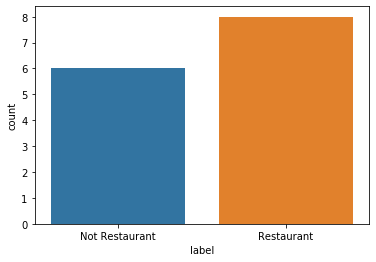

In [139]:
sns.countplot(gianyar_dataframe.label)

([<matplotlib.patches.Wedge at 0x1970b25bd88>,
 [Text(-0.24477311341532162, 1.0724206837565984, 'Restaurant'),
  Text(0.24477321382259096, -1.072420660839281, 'Not Restaurant')],
 [Text(-0.13351260731744813, 0.5849567365945082, '57.1%'),
  Text(0.13351266208504958, -0.5849567240941532, '42.9%')])

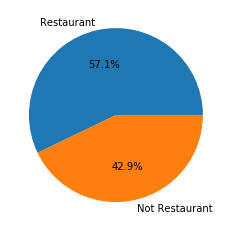

In [141]:
plt.pie(gianyar_dataframe.label.value_counts(),labels=['Restaurant','Not Restaurant'],autopct='%1.1f%%')

In [144]:
gianyar_map = folium.Map(location=(gianyar_loc.latitude,gianyar_loc.longitude),zoom_start=15)

In [145]:
colors = ['#009933','#0000ff']
for lat, lng, name, c in zip(gianyar_dataframe['lat'], gianyar_dataframe['lng'], gianyar_dataframe['name'],gianyar_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(gianyar_map)
gianyar_map 

In [146]:
karangasem_loc  = geolocator.geocode('Karangasem, Bali')

In [147]:
print(f"Location of Karangasem in Bali latitude {karangasem_loc.latitude} and longintude {karangasem_loc.longitude}.")

Location of Karangasem in Bali latitude -8.4464252 and longintude 115.6135572.


In [202]:
karangasem_map = folium.Map(location=(karangasem_loc.latitude,karangasem_loc.longitude),zoom_start=12)
karangasem_map

In [181]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {karangasem_loc.latitude},{karangasem_loc.longitude}&locate=id&near'

In [182]:
result = requests.get(url).json()

In [183]:
venues = result['response']['groups'][0]['items']
karangasem_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
karangasem_dataframe =karangasem_dataframe.loc[:, filtered_columns]
karangasem_dataframe['venue.categories'] = karangasem_dataframe.apply(get_category_type, axis=1)
karangasem_dataframe.columns = [col.split(".")[-1] for col in karangasem_dataframe.columns]
display(karangasem_dataframe.head())
print('data shape :',karangasem_dataframe.shape)

,name,categories,lat,lng
0,Sekar Bali Restaurant,Indonesian Restaurant,-8.448474,115.608788
1,Taman Ujung,Garden,-8.464247,115.631068
2,Sensatia Botanicals - Bali Production Facility...,Cosmetics Shop,-8.476611,115.620147
3,Bali Asli Restaurant,Sri Lankan Restaurant,-8.426630,115.607402
4,Tirta Gangga Water Palace,Temple,-8.412110,115.586994


data shape : (30, 4)


In [184]:
karangasem_dataframe['label'] = karangasem_dataframe['categories'].apply(get_label)

In [185]:
karangasem_dataframe

,name,categories,lat,lng,label
0,Sekar Bali Restaurant,Indonesian Restaurant,-8.448474,115.608788,Restaurant
1,Taman Ujung,Garden,-8.464247,115.631068,Not Restaurant
2,Sensatia Botanicals - Bali Production Facility...,Cosmetics Shop,-8.476611,115.620147,Not Restaurant
3,Bali Asli Restaurant,Sri Lankan Restaurant,-8.426630,115.607402,Restaurant
4,Tirta Gangga Water Palace,Temple,-8.412110,115.586994,Not Restaurant
5,Taman Ujung Soekasada,Park,-8.463605,115.631184,Not Restaurant
6,Juice Corner,Café,-8.456355,115.601930,Restaurant
7,Tirta Gangga,Water Park,-8.412090,115.587186,Not Restaurant
8,Villa Matanai,Resort,-8.482219,115.618146,Not Restaurant
9,Virgin Beach,Beach,-8.497855,115.610862,Not Restaurant


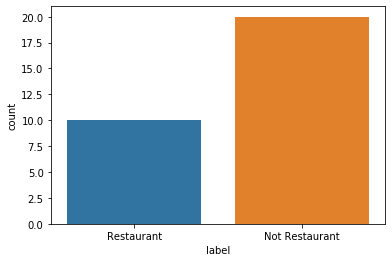

In [156]:
sns.countplot(karangasem_dataframe.label)

([<matplotlib.patches.Wedge at 0x1970b664848>,
 [Text(-0.5500000594609755, 0.9526279098330699, 'Not Restaurant'),
  Text(0.5500001486524352, -0.9526278583383436, 'Restaurant')],
 [Text(-0.30000003243325934, 0.5196152235453108, '66.7%'),
  Text(0.30000008108314646, -0.5196151954572783, '33.3%')])

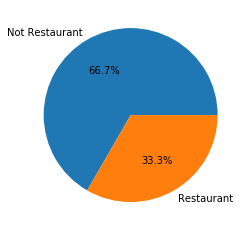

In [158]:
plt.pie(karangasem_dataframe.label.value_counts(),labels=['Not Restaurant','Restaurant'],autopct='%1.1f%%')

In [166]:
karangasem_map = folium.Map(location=(karangasem_loc.latitude,karangasem_loc.longitude),zoom_start=12)

In [167]:
colors = ['#009933','#0000ff']
for lat, lng, name, c in zip(karangasem_dataframe['lat'], karangasem_dataframe['lng'], karangasem_dataframe['name'],karangasem_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(karangasem_map)
karangasem_map 

In [168]:
klungkung_loc  = geolocator.geocode('klungkung, Bali')

In [169]:
print(f"Location of Klungkung in Bali latitude {klungkung_loc.latitude} and longintude {klungkung_loc.longitude}.")

Location of Klungkung in Bali latitude -8.5350173 and longintude 115.4032763.


In [172]:
klungkung_map = folium.Map(location=(klungkung_loc.latitude,klungkung_loc.longitude),zoom_start=14)
klungkung_map

In [186]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {klungkung_loc.latitude},{klungkung_loc.longitude}&locate=id&near'

In [187]:
result = requests.get(url).json()

In [188]:
venues = result['response']['groups'][0]['items']
klungkung_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
klungkung_dataframe =klungkung_dataframe.loc[:, filtered_columns]
klungkung_dataframe['venue.categories'] = klungkung_dataframe.apply(get_category_type, axis=1)
klungkung_dataframe.columns = [col.split(".")[-1] for col in klungkung_dataframe.columns]
display(klungkung_dataframe.head())
print('data shape :',klungkung_dataframe.shape)

,name,categories,lat,lng
0,Pasar Klungkung,Department Store,-8.535816,115.404611
1,Taman Gili Kerta Gosa,History Museum,-8.535571,115.403552
2,Kertha Gosa Klungkung,Historic Site,-8.535742,115.403627
3,Pasar Sengol Klungkung (Night Market ),Night Market,-8.534833,115.404283
4,Waroeng Sari Rasa,Café,-8.531709,115.400820


data shape : (12, 4)


In [189]:
klungkung_dataframe['label'] = klungkung_dataframe['categories'].apply(get_label)

In [190]:
klungkung_dataframe

,name,categories,lat,lng,label
0,Pasar Klungkung,Department Store,-8.535816,115.404611,Not Restaurant
1,Taman Gili Kerta Gosa,History Museum,-8.535571,115.403552,Not Restaurant
2,Kertha Gosa Klungkung,Historic Site,-8.535742,115.403627,Not Restaurant
3,Pasar Sengol Klungkung (Night Market ),Night Market,-8.534833,115.404283,Not Restaurant
4,Waroeng Sari Rasa,Café,-8.531709,115.400820,Restaurant
5,KERTAGOSA Museum Temple,History Museum,-8.535729,115.403477,Not Restaurant
6,Rumah Makan Rajawali,Indonesian Restaurant,-8.535003,115.404559,Restaurant
7,Lapangan Puputan Klungkung,Field,-8.535707,115.401556,Not Restaurant
8,Pasar Galiran Klungkung,Miscellaneous Shop,-8.543822,115.401805,Not Restaurant
9,Pasar Senggol Klungkung,Food Truck,-8.535520,115.403500,Restaurant


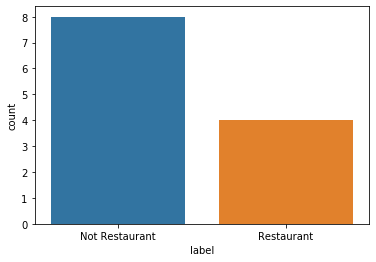

In [191]:
sns.countplot(klungkung_dataframe.label)

([<matplotlib.patches.Wedge at 0x1970b903548>,
 [Text(-0.5500000594609755, 0.9526279098330699, 'Not Restaurant'),
  Text(0.5500001486524352, -0.9526278583383436, 'Restaurant')],
 [Text(-0.30000003243325934, 0.5196152235453108, '66.7%'),
  Text(0.30000008108314646, -0.5196151954572783, '33.3%')])

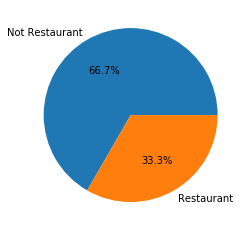

In [193]:
plt.pie(klungkung_dataframe.label.value_counts(),labels=['Not Restaurant','Restaurant'],autopct='%1.1f%%')

In [198]:
klungkung_map = folium.Map(location=(klungkung_loc.latitude,klungkung_loc.longitude),zoom_start=15)

In [200]:
colors = ['#009933','#0000ff']
for lat, lng, name, c in zip(klungkung_dataframe['lat'], klungkung_dataframe['lng'], klungkung_dataframe['name'],klungkung_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(klungkung_map)
klungkung_map 

In [203]:
tabanan_loc  = geolocator.geocode('tabanan, Bali')

In [204]:
print(f"Location of Tabanan in Bali latitude {tabanan_loc.latitude} and longintude {tabanan_loc.longitude}.")

Location of Tabanan in Bali latitude -8.5392306 and longintude 115.1265683.


In [209]:
tabanan_map = folium.Map(location=(tabanan_loc.latitude,tabanan_loc.longitude),zoom_start=12)
tabanan_map

In [207]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {tabanan_loc.latitude},{tabanan_loc.longitude}&locate=id&near'

In [208]:
result = requests.get(url).json()

In [210]:
venues = result['response']['groups'][0]['items']
tabanan_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
tabanan_dataframe =tabanan_dataframe.loc[:, filtered_columns]
tabanan_dataframe['venue.categories'] = tabanan_dataframe.apply(get_category_type, axis=1)
tabanan_dataframe.columns = [col.split(".")[-1] for col in tabanan_dataframe.columns]
display(tabanan_dataframe.head())
print('data shape :',tabanan_dataframe.shape)

,name,categories,lat,lng
0,"Warung nasi lawar ""asri jambe""",Indonesian Restaurant,-8.533742,115.123815
1,Senggol tabanan,Breakfast Spot,-8.539586,115.126305
2,Sengol tabanan,Food Court,-8.549521,115.122806
3,Pasar Kodok (Frog Market),Clothing Store,-8.545347,115.121382
4,Pasar Senggol Tabanan,Food Truck,-8.549346,115.125702


data shape : (15, 4)


In [212]:
tabanan_dataframe['label'] = tabanan_dataframe['categories'].apply(get_label)

In [213]:
tabanan_dataframe

,name,categories,lat,lng,label
0,"Warung nasi lawar ""asri jambe""",Indonesian Restaurant,-8.533742,115.123815,Restaurant
1,Senggol tabanan,Breakfast Spot,-8.539586,115.126305,Restaurant
2,Sengol tabanan,Food Court,-8.549521,115.122806,Restaurant
3,Pasar Kodok (Frog Market),Clothing Store,-8.545347,115.121382,Not Restaurant
4,Pasar Senggol Tabanan,Food Truck,-8.549346,115.125702,Restaurant
5,Conato Bakery,Bakery,-8.539444,115.125946,Restaurant
6,Warung Kenanga,Chinese Restaurant,-8.540711,115.126077,Restaurant
7,Pasar Tabanan,Farmers Market,-8.539088,115.126223,Not Restaurant
8,Taman Kota Tabanan,Other Great Outdoors,-8.537800,115.126211,Not Restaurant
9,Pasar Tabanan,Market,-8.538958,115.125800,Not Restaurant


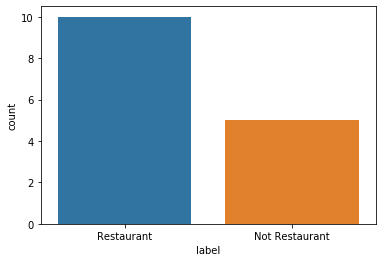

In [214]:
sns.countplot(tabanan_dataframe.label)

([<matplotlib.patches.Wedge at 0x1970add5488>,
 [Text(-0.5500000594609755, 0.9526279098330699, 'Restaurant'),
  Text(0.5500001486524352, -0.9526278583383436, 'Not Restaurant')],
 [Text(-0.30000003243325934, 0.5196152235453108, '66.7%'),
  Text(0.30000008108314646, -0.5196151954572783, '33.3%')])

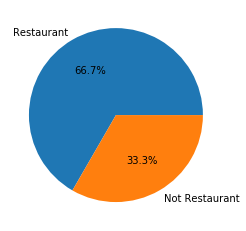

In [215]:
plt.pie(tabanan_dataframe.label.value_counts(),labels=['Restaurant','Not Restaurant'],autopct='%1.1f%%')

In [216]:
tabanan_map = folium.Map(location=(tabanan_loc.latitude,tabanan_loc.longitude),zoom_start=15)

In [217]:
colors = ['#009933','#0000ff']
for lat, lng, name, c in zip(tabanan_dataframe['lat'], tabanan_dataframe['lng'], tabanan_dataframe['name'],tabanan_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tabanan_map)
tabanan_map 

In [219]:
denpasar_loc  = geolocator.geocode('Denpasar, Bali')

In [220]:
print(f"Location of Denpasar in Bali latitude {denpasar_loc.latitude} and longintude {denpasar_loc.longitude}.")

Location of Denpasar in Bali latitude -8.6524973 and longintude 115.2191175.


In [328]:
denpasar_map = folium.Map(location=(denpasar_loc.latitude,denpasar_loc.longitude),zoom_start=12)
denpasar_map

In [222]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {denpasar_loc.latitude},{denpasar_loc.longitude}&locate=id&near'

In [223]:
result = requests.get(url).json()

In [224]:
venues = result['response']['groups'][0]['items']
denpasar_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
denpasar_dataframe =denpasar_dataframe.loc[:, filtered_columns]
denpasar_dataframe['venue.categories'] = denpasar_dataframe.apply(get_category_type, axis=1)
denpasar_dataframe.columns = [col.split(".")[-1] for col in denpasar_dataframe.columns]
display(denpasar_dataframe.head())
print('data shape :',denpasar_dataframe.shape)

,name,categories,lat,lng
0,Dapoer Pemuda,Indonesian Restaurant,-8.653717,115.217061
1,Voltvet Eatery & Coffee,Café,-8.653594,115.217020
2,Warung Wardani,Indonesian Restaurant,-8.651159,115.215957
3,Mitos Kopi,Coffee Shop,-8.653779,115.215148
4,Patung Catur Muka,Monument / Landmark,-8.656036,115.216993


data shape : (30, 4)


In [228]:
denpasar_dataframe['label'] = denpasar_dataframe['categories'].apply(get_label)

In [229]:
denpasar_dataframe

,name,categories,lat,lng,label
0,Dapoer Pemuda,Indonesian Restaurant,-8.653717,115.217061,Restaurant
1,Voltvet Eatery & Coffee,Café,-8.653594,115.217020,Restaurant
2,Warung Wardani,Indonesian Restaurant,-8.651159,115.215957,Restaurant
3,Mitos Kopi,Coffee Shop,-8.653779,115.215148,Restaurant
4,Patung Catur Muka,Monument / Landmark,-8.656036,115.216993,Not Restaurant
5,Home Bistro,Coffee Shop,-8.649408,115.220853,Restaurant
6,Playboy's Coffee House,Coffee Shop,-8.649234,115.221453,Restaurant
7,Warung Rujak Bisma,Salad Place,-8.650706,115.214355,Not Restaurant
8,Kober Mie Setan Kaliasem,Noodle House,-8.655080,115.218596,Restaurant
9,Sate Plecing Arjuna,Satay Restaurant,-8.652880,115.215462,Restaurant


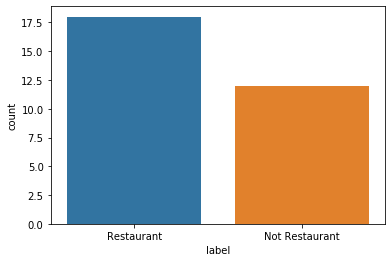

In [230]:
sns.countplot(denpasar_dataframe.label)

([<matplotlib.patches.Wedge at 0x1970b828c88>,
 [Text(-0.33991877217145816, 1.046162142464278, 'Restaurant'),
  Text(0.3399188701202255, -1.0461621106387813, 'Not Restaurant')],
 [Text(-0.18541023936624987, 0.5706338958896061, '60.0%'),
  Text(0.18541029279285026, -0.5706338785302443, '40.0%')])

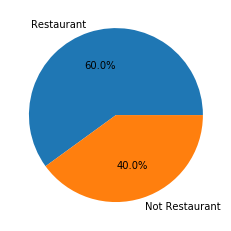

In [231]:
plt.pie(denpasar_dataframe.label.value_counts(),labels=['Restaurant','Not Restaurant'],autopct='%1.1f%%')

In [234]:
denpasar_map = folium.Map(location=(denpasar_loc.latitude,denpasar_loc.longitude),zoom_start=16)

In [235]:
colors = ['#009933','#0000ff']
for lat, lng, name, c in zip(denpasar_dataframe['lat'], denpasar_dataframe['lng'], denpasar_dataframe['name'],denpasar_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(denpasar_map)
denpasar_map 

In [414]:
jembrana_loc  = geolocator.geocode('Negara, Bali')

In [415]:
print(f"Location of Jembrana in Bali latitude {jembrana_loc.latitude} and longintude {jembrana_loc.longitude}.")

Location of Jembrana in Bali latitude -8.3585536 and longintude 114.6218756.


In [416]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {jembrana_loc.latitude},{jembrana_loc.longitude}&locate=id&near'
result = requests.get(url).json()
venues = result['response']['groups'][0]['items']
jembrana_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
jembrana_dataframe =jembrana_dataframe.loc[:, filtered_columns]
jembrana_dataframe['venue.categories'] = jembrana_dataframe.apply(get_category_type, axis=1)
jembrana_dataframe.columns = [col.split(".")[-1] for col in jembrana_dataframe.columns]
display(jembrana_dataframe.head())
print('data shape :',jembrana_dataframe.shape)
jembrana_dataframe['label'] = jembrana_dataframe['categories'].apply(get_label)
display(jembrana_dataframe)

,name,categories,lat,lng
0,Pasar Senggol Terminal Negara,Diner,-8.359315,114.625844
1,"Warung Betutu ""Beten Duren""",Breakfast Spot,-8.353914,114.634498
2,Rosari Cake & Bakery,Bakery,-8.360775,114.623480
3,Pasar Senggol Negara,Diner,-8.359384,114.625948
4,"Warung Makan Muslim ""MADINA""",Indonesian Restaurant,-8.354360,114.606017


data shape : (10, 4)


,name,categories,lat,lng,label
0,Pasar Senggol Terminal Negara,Diner,-8.359315,114.625844,Not Restaurant
1,"Warung Betutu ""Beten Duren""",Breakfast Spot,-8.353914,114.634498,Restaurant
2,Rosari Cake & Bakery,Bakery,-8.360775,114.623480,Restaurant
3,Pasar Senggol Negara,Diner,-8.359384,114.625948,Not Restaurant
4,"Warung Makan Muslim ""MADINA""",Indonesian Restaurant,-8.354360,114.606017,Restaurant
5,Twins Tower,Building,-8.359701,114.636111,Not Restaurant
6,Taman Kota Negara,Campground,-8.357069,114.631820,Not Restaurant
7,Hardy's,Grocery Store,-8.360341,114.627823,Not Restaurant
8,Warung Sri,Indonesian Restaurant,-8.356505,114.621530,Restaurant
9,Hotel Jimbarwana Negara,Hotel,-8.356696,114.620617,Not Restaurant


In [417]:
colors = ['#009933','#0000ff']
jembrana_map = folium.Map(location=(jembrana_loc.latitude,jembrana_loc.longitude),zoom_start=12)
for lat, lng, name, c in zip(jembrana_dataframe['lat'], jembrana_dataframe['lng'], jembrana_dataframe['name'],jembrana_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(jembrana_map)
jembrana_map 

In [339]:
badung_loc  = geolocator.geocode('badung, Bali')

In [489]:
print(f"Location of Badung in Bali latitude {badung_loc.latitude} and longintude {badung_loc.longitude}.")

Location of Badung in Bali latitude -8.6240702 and longintude 115.44346444653527.


In [490]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll=         {badung_loc.latitude},{badung_loc.longitude}&locate=id&near'
result = requests.get(url).json()
venues = result['response']['groups'][0]['items']
badung_dataframe = pd.io.json.json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
badung_dataframe =badung_dataframe.loc[:, filtered_columns]
badung_dataframe['venue.categories'] = badung_dataframe.apply(get_category_type, axis=1)
badung_dataframe.columns = [col.split(".")[-1] for col in badung_dataframe.columns]
display(badung_dataframe.head())
print('data shape :',badung_dataframe.shape)
badung_dataframe['label'] = badung_dataframe['categories'].apply(get_label)
display(badung_dataframe)

,name,categories,lat,lng
0,Mangrove Beach,Beach,-8.666345,115.464161
1,Indiana Kenanga,Resort,-8.668557,115.448101
2,Warung Bambu,Fish & Chips Shop,-8.663779,115.455872
3,Blue Corner Dive Lembongan,Dive Shop,-8.666424,115.448900
4,Bali Eco Deli,Coffee Shop,-8.671958,115.449336


data shape : (30, 4)


,name,categories,lat,lng,label
0,Mangrove Beach,Beach,-8.666345,115.464161,Not Restaurant
1,Indiana Kenanga,Resort,-8.668557,115.448101,Not Restaurant
2,Warung Bambu,Fish & Chips Shop,-8.663779,115.455872,Restaurant
3,Blue Corner Dive Lembongan,Dive Shop,-8.666424,115.448900,Not Restaurant
4,Bali Eco Deli,Coffee Shop,-8.671958,115.449336,Restaurant
5,Pisang-Pisang,Juice Bar,-8.668752,115.449562,Restaurant
6,World Diving Lembongan,Resort,-8.673339,115.447288,Not Restaurant
7,Big Fish Diving,Dive Shop,-8.673561,115.448316,Not Restaurant
8,Pantai Jungutbatu,Beach,-8.676382,115.446750,Not Restaurant
9,Dream Beach,Beach,-8.690546,115.432914,Not Restaurant


In [491]:
colors = ['#009933','#0000ff']
badung_map = folium.Map(location=(badung_loc.latitude,badung_loc.longitude),zoom_start=12)
for lat, lng, name, c in zip(badung_dataframe['lat'], badung_dataframe['lng'], badung_dataframe['name'],badung_dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(badung_map)
badung_map 

## Methodology <a name="methodology"></a>

In first step we have collected the required data: location and type (category) of every restaurant for each regency or city. 


Second step in our analysis will look for industrial densities that are likely to influence future result, then look for places that have the highest average number of tourist visiting each regency or city

in third and final step, we will focus on finding the best position from analysis that we have.

## Analysis <a name="analysis"></a>


Let's perform some basic explanatory data analysis and derive some additional info from our raw data. in here we take data from Department Statistics Bali Regency https://bali.bps.go.id/

In [251]:
data = 'Book1.xlsx'

In [253]:
df_1 = pd.read_excel(data)

In [254]:
df_1

,Kabupaten/Kota,Januari_2007,Februari_2007,Maret_2007,April_2007,Mei_2007,Juni_2007,Juli_2007,Agustus_2007,September_2007,...,Maret_2019,April_2019,Mei_2019,Juni_2019,Juli_2019,Agustus_2019,September_2019,Oktober_2019,November_2019,Desember_2018.1
0,Kab. Jembrana,-,17.30,19.65,19.89,21.26,20.34,17.14,17.34,26.71,...,13.98,11.15,11.78,11.98,11.47,12.37,13.57,12.27,13.82,12.99
1,Kab. Tabanan,-,26.11,17.75,14.24,16.72,8.02,8.34,14.52,22.54,...,17.77,16.93,23.13,18.27,18.26,16.43,16.89,15.38,17.38,16.40
2,Kab. Badung,-,43.40,44.15,40.45,40.09,46.29,44.20,56.39,51.50,...,44.94,46.80,38.67,54.01,51.68,53.08,52.06,50.22,46.48,50.28
3,Kab. Gianyar,-,16.83,17.26,17.21,16.53,11.95,23.88,22.25,16.44,...,36.62,38.92,37.80,37.88,43.23,49.88,44.70,39.77,32.86,35.49
4,Kab. Klungkung,-,9.91,9.70,14.74,14.29,16.72,2.62,7.62,9.81,...,60.86,53.44,76.96,59.81,73.00,58.71,67.05,77.05,54.19,59.63
5,Kab. Bangli,-,15.00,19.59,21.44,16.49,21.44,24.75,39.97,16.80,...,6.90,12.77,10.08,10.21,11.48,11.80,10.67,8.96,13.70,14.96
6,Kab. Karangasem,-,6.14,16.40,11.18,21.40,15.19,27.14,20.41,16.62,...,24.82,25.08,24.33,31.64,38.00,39.91,35.34,27.86,29.95,24.41
7,Kab. Buleleng,-,16.95,19.86,17.00,19.60,19.38,23.42,26.33,21.01,...,15.48,18.50,16.37,20.30,24.69,26.89,21.76,20.19,15.96,18.56
8,Kota Denpasar,-,19.25,13.00,24.01,25.62,31.76,30.54,31.36,32.96,...,16.83,22.22,19.91,22.65,23.44,21.37,18.39,19.41,19.48,29.22


In [308]:
df_1.drop('Januari_2007',axis=1,inplace=True)

In [317]:
df_1['AVG'] = df_1.sum(axis=1) / 156

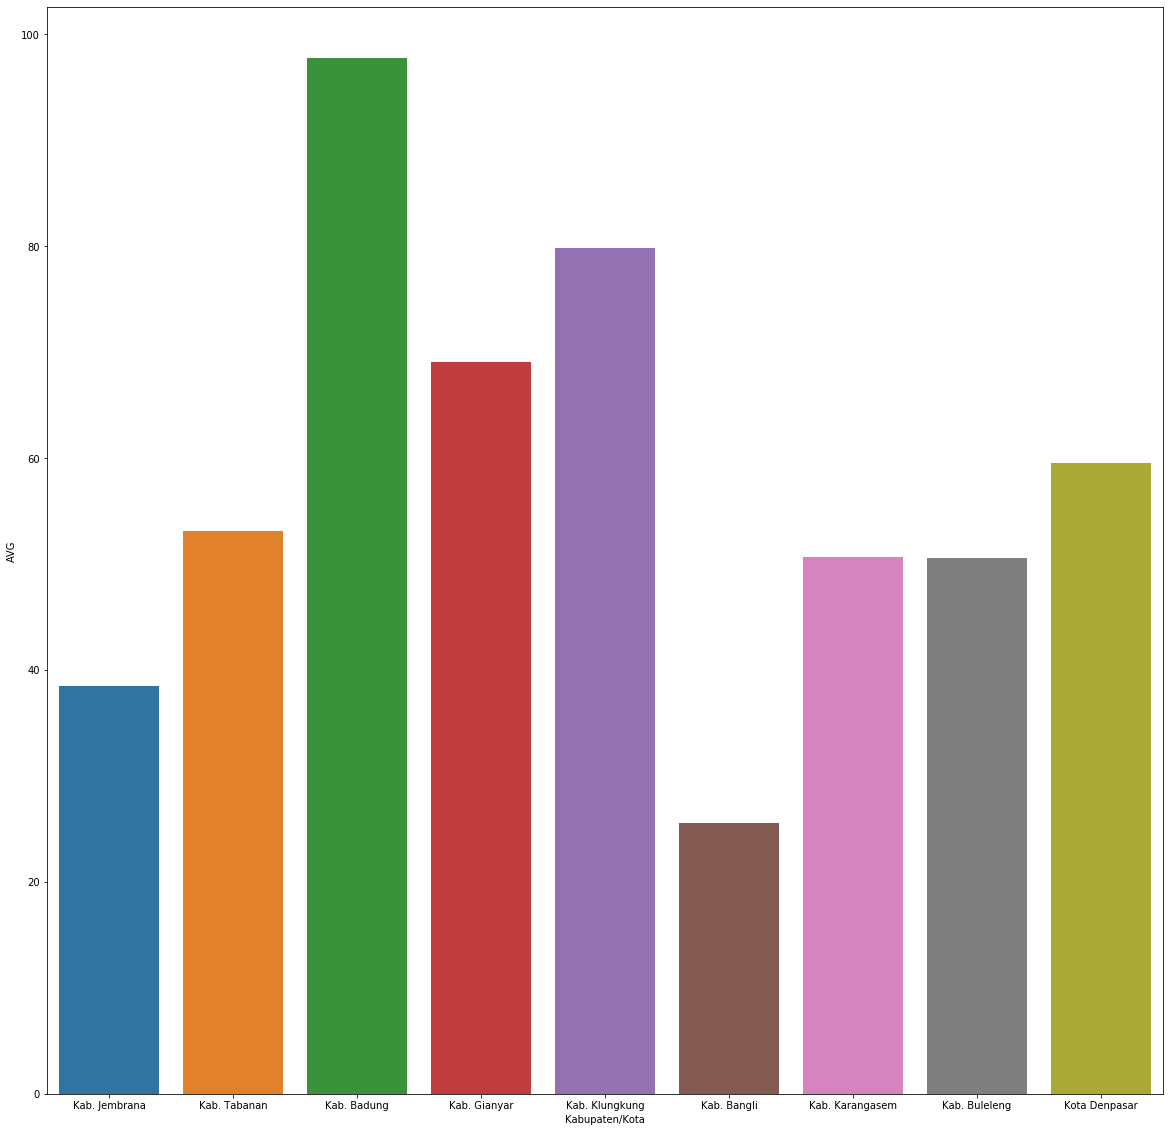

In [349]:
plt.figure(figsize=(20,20))
sns.barplot(x='Kabupaten/Kota',y='AVG',data=df_1)

the majority of tourists on average they stay in an area for at least 1 month, and the area of ​​greatest interest is Badung

In [350]:
df_2 = pd.read_excel('Number_of_Restaurant_By_Regency,2012-2019.xlsx')

In [352]:
df_2

,Kabupaten/Kota,2012,2013,2014,2015,2016,2017,2018,2019
0,Jembrana,136,136,76,76,76,76,76,134
1,Tabanan,40,40,32,32,32,40,40,80
2,Badung,623,96,833,825,823,823,823,823
3,Gianyar,238,378,405,504,504,505,622,612
4,Klungkung,39,31,31,31,31,31,146,243
5,Bangli,39,17,17,17,22,30,36,44
6,Karangasem,95,246,70,70,118,118,120,146
7,Buleleng,53,53,145,173,173,173,200,200
8,Denpasar,76,72,449,449,438,455,455,582


In [367]:
df_2.rename(columns={2012:'year_2012',2013:'year_2013',2014:'year_2014',2015:'year_2015',2016:'year_20216',2017:'year_2017',2018:'year_2018',2019:'year_2019'},inplace=True)

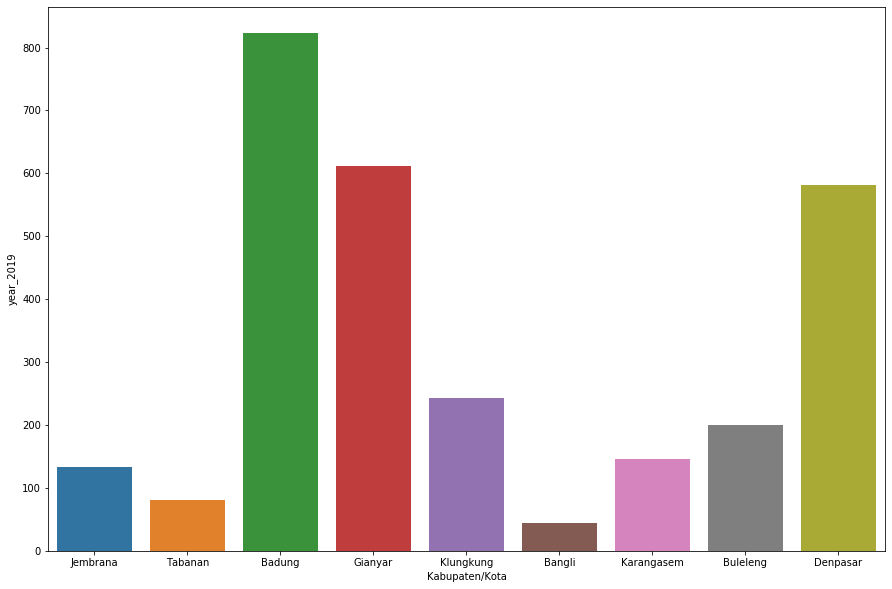

In [373]:
plt.figure(figsize=(15,10))
sns.barplot(x='Kabupaten/Kota',y='year_2019',data=df_2)

in here Badung,Gianyar and Denpasar having big number for restaurant

In [375]:
df_3 = pd.read_excel('Number_of_Travel_Bureau_by_Regency,2012-2019.xlsx')

In [376]:
df_3

,Kabupaten/Kota,2012,2013,2014,2015,2016,2017,2018,2019
0,Jembrana,0,0,0,0,0,0,0,0
1,Tabanan,3,3,3,3,3,3,3,4
2,Badung,116,117,129,131,132,135,135,143
3,Gianyar,15,17,19,19,20,20,20,20
4,Klungkung,0,0,1,1,1,1,1,1
5,Bangli,1,1,1,1,1,1,1,2
6,Karangasem,1,1,1,1,1,1,1,2
7,Buleleng,0,0,1,1,1,1,1,1
8,Denpasar,198,220,211,211,213,243,243,243


In [377]:
df_3.rename(columns={2012:'year_2012',2013:'year_2013',2014:'year_2014',2015:'year_2015',2016:'year_20216',2017:'year_2017',2018:'year_2018',2019:'year_2019'},inplace=True)

In [378]:
df_3

,Kabupaten/Kota,year_2012,year_2013,year_2014,year_2015,year_20216,year_2017,year_2018,year_2019
0,Jembrana,0,0,0,0,0,0,0,0
1,Tabanan,3,3,3,3,3,3,3,4
2,Badung,116,117,129,131,132,135,135,143
3,Gianyar,15,17,19,19,20,20,20,20
4,Klungkung,0,0,1,1,1,1,1,1
5,Bangli,1,1,1,1,1,1,1,2
6,Karangasem,1,1,1,1,1,1,1,2
7,Buleleng,0,0,1,1,1,1,1,1
8,Denpasar,198,220,211,211,213,243,243,243


In [492]:
df = pd.concat([denpasar_dataframe,badung_dataframe,gianyar_dataframe],axis=0)

In [448]:
df

,name,categories,lat,lng,label
0,Dapoer Pemuda,Indonesian Restaurant,-8.653717,115.217061,Restaurant
1,Voltvet Eatery & Coffee,Café,-8.653594,115.217020,Restaurant
2,Warung Wardani,Indonesian Restaurant,-8.651159,115.215957,Restaurant
3,Mitos Kopi,Coffee Shop,-8.653779,115.215148,Restaurant
4,Patung Catur Muka,Monument / Landmark,-8.656036,115.216993,Not Restaurant
...,...,...,...,...,...
9,Babi Guling Senggol Gianyar,BBQ Joint,-8.541543,115.326482,Restaurant
10,Rumah Makan Taliwang,Fried Chicken Joint,-8.541125,115.334868,Restaurant
11,Q Mart,Food Truck,-8.540783,115.322428,Restaurant
12,Warung WBA Gianyar,Seafood Restaurant,-8.540710,115.320100,Restaurant


In [449]:
recommend_restaurant = df[df['label'] == 'Restaurant']

In [450]:
geolocator = geopy.Nominatim(user_agent='hanyacontohemail@gmail.com')
bali_loc  = geolocator.geocode('Bali, Indonesia')

In [451]:
bali_map = folium.Map(location=(bali_loc.latitude,bali_loc.longitude),zoom_start=10)
for lat, lng, name, c in zip(recommend_restaurant['lat'], recommend_restaurant['lng'], recommend_restaurant['name'],recommend_restaurant['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bali_map)
bali_map 

In [452]:
from sklearn.cluster import KMeans

In [453]:
recommend_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 13
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        39 non-null     object 
 1   categories  39 non-null     object 
 2   lat         39 non-null     float64
 3   lng         39 non-null     float64
 4   label       39 non-null     object 
dtypes: float64(2), object(3)
memory usage: 1.8+ KB


In [454]:
kmeans = KMeans(n_clusters=1)
kmeans.fit(recommend_restaurant[['lat','lng']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [481]:
center = kmeans.cluster_centers_
print(center)

[[ -8.63571293 115.31829255]]


In [479]:
bali_map = folium.Map(location=(bali_loc.latitude-0.3,bali_loc.longitude+0.2),zoom_start=11)
for lat, lng in center:
    folium.CircleMarker(
        [lat, lng],
        radius=250,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3).add_to(bali_map)
bali_map 

In [480]:
for lat, lng, name, c in zip(recommend_restaurant['lat'], recommend_restaurant['lng'], recommend_restaurant['name'],recommend_restaurant['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bali_map)
bali_map 

In [482]:
url = f'https://api.foursquare.com/v2/venues/explore?&client_id={client_id}&client_secret={client_secret}&v={v}&ll={-8.63571293},{115.31829255}&radius=5000'

In [483]:
results = requests.get(url).json()["response"]['groups'][0]['items']

In [487]:
dataframe = pd.io.json.json_normalize(results)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
dataframe =dataframe.loc[:, filtered_columns]
dataframe['venue.categories'] = dataframe.apply(get_category_type, axis=1)
dataframe.columns = [col.split(".")[-1] for col in dataframe.columns]
display(dataframe.head())
print('data shape :',dataframe.shape)
dataframe['label'] = dataframe['categories'].apply(get_label)
display(dataframe)

,name,categories,lat,lng
0,Standing Stones,Restaurant,-8.619263,115.308572
1,Pantai Purnama,Beach,-8.618649,115.309850
2,Villa Anapuri Pabean Beach,Resort,-8.627419,115.301275
3,Purnama Beach Villas,Resort,-8.618259,115.308864
4,Hidden Canyon Beji Guwang,Nature Preserve,-8.608931,115.289878


data shape : (25, 4)


,name,categories,lat,lng,label
0,Standing Stones,Restaurant,-8.619263,115.308572,Restaurant
1,Pantai Purnama,Beach,-8.618649,115.309850,Not Restaurant
2,Villa Anapuri Pabean Beach,Resort,-8.627419,115.301275,Not Restaurant
3,Purnama Beach Villas,Resort,-8.618259,115.308864,Not Restaurant
4,Hidden Canyon Beji Guwang,Nature Preserve,-8.608931,115.289878,Not Restaurant
5,Komune Resort and Beach Club,Resort,-8.598222,115.338460,Not Restaurant
6,Bali Floating Leaf Eco-Retreat,Resort,-8.608413,115.309736,Not Restaurant
7,Black Sands,Italian Restaurant,-8.635213,115.283270,Restaurant
8,Jeeva Saba Bali,Resort,-8.611763,115.321652,Not Restaurant
9,Keramas Beach,Surf Spot,-8.599086,115.337532,Not Restaurant


In [498]:
bali_map = folium.Map(location=(bali_loc.latitude-0.3,bali_loc.longitude+0.2),zoom_start=11)
for lat, lng, name, c in zip(dataframe['lat'], dataframe['lng'], dataframe['name'],dataframe['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bali_map)
bali_map 

In [494]:
df = pd.concat([df,dataframe],axis=0)

In [495]:
df

,name,categories,lat,lng,label
0,Dapoer Pemuda,Indonesian Restaurant,-8.653717,115.217061,Restaurant
1,Voltvet Eatery & Coffee,Café,-8.653594,115.217020,Restaurant
2,Warung Wardani,Indonesian Restaurant,-8.651159,115.215957,Restaurant
3,Mitos Kopi,Coffee Shop,-8.653779,115.215148,Restaurant
4,Patung Catur Muka,Monument / Landmark,-8.656036,115.216993,Not Restaurant
...,...,...,...,...,...
20,Bali Safari n Marine Park Tsavo Resto,Park,-8.617651,115.283559,Not Restaurant
21,Warung Manis,Restaurant,-8.615525,115.278963,Restaurant
22,KamasanBali® Office,Jewelry Store,-8.644460,115.274281,Not Restaurant
23,Cirkle K,Grocery Store,-8.646719,115.274397,Not Restaurant


In [499]:
for lat, lng, name, c in zip(df['lat'], df['lng'], df['name'],df['label']):
    if c == 'Restaurant':
        color_index = 1
    else:
        color_index = 0
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[color_index],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bali_map)
bali_map 

In [497]:
for lat, lng in center:
    folium.CircleMarker(
        [lat, lng],
        radius=250,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3).add_to(bali_map)
bali_map 

In [500]:
df.head()

,name,categories,lat,lng,label
0,Dapoer Pemuda,Indonesian Restaurant,-8.653717,115.217061,Restaurant
1,Voltvet Eatery & Coffee,Café,-8.653594,115.217020,Restaurant
2,Warung Wardani,Indonesian Restaurant,-8.651159,115.215957,Restaurant
3,Mitos Kopi,Coffee Shop,-8.653779,115.215148,Restaurant
4,Patung Catur Muka,Monument / Landmark,-8.656036,115.216993,Not Restaurant


In [502]:
df.categories.value_counts()

Resort                       13
Beach                         8
Convenience Store             7
Restaurant                    7
Indonesian Restaurant         7
Coffee Shop                   5
Hotel                         4
Grocery Store                 4
Park                          4
Noodle House                  3
Balinese Restaurant           3
Dive Shop                     3
Stables                       2
Café                          2
Scenic Lookout                2
Nature Preserve               2
Italian Restaurant            2
BBQ Joint                     2
Dive Spot                     2
Beach Bar                     2
Seafood Restaurant            2
Food & Drink Shop             2
Soccer Field                  2
Art Gallery                   2
Bakery                        2
Surf Spot                     2
Jewelry Store                 2
Field                         1
Cosmetics Shop                1
History Museum                1
Asian Restaurant              1
Basketba

In [515]:
df[df['label'] == 'Restaurant']['categories'].value_counts()

Restaurant                   7
Indonesian Restaurant        7
Coffee Shop                  5
Balinese Restaurant          3
Noodle House                 3
Italian Restaurant           2
Beach Bar                    2
Café                         2
Bakery                       2
Food & Drink Shop            2
Seafood Restaurant           2
BBQ Joint                    2
Food Truck                   1
Pizza Place                  1
Asian Restaurant             1
French Restaurant            1
Chinese Restaurant           1
Fish & Chips Shop            1
Juice Bar                    1
Fried Chicken Joint          1
Middle Eastern Restaurant    1
Satay Restaurant             1
Name: categories, dtype: int64

# Results and Discussion <a name="results"></a>

now, after analyzing data from foursquare, department statistics bali and wikipedia, we can conclusion that the best location for open restaurant in denpasar, gianyar, or badung. in denpasar you can open Indonesian restaurant in there, denpasar is the best place that if you focusing costumer who want to going to airport or harbor. after that for badung is very stategy place for open restaurant but it will dificult if you didn't have much marketing strategy. and the last is gianyar. if you want to safe play you can try that because cooperating with service providers there

# Conclusion <a name="conclusion"></a>

the final is for each place having plus and minus, it's dependent with your situation which situation you want to.